<a href="https://colab.research.google.com/github/linjikai/ai/blob/master/%E5%AE%98%E6%96%B9%E4%BB%A3%E7%A0%81%E6%94%B9%E9%80%A0Bert%E4%B8%AD%E6%96%87%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 19.0MB/s 


In [3]:
pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 17.3MB/s 
     |████████████████████████████████| 706kB 51.6MB/s 
     |████████████████████████████████| 1.2MB 54.8MB/s 
     |████████████████████████████████| 645kB 47.4MB/s 
     |████████████████████████████████| 358kB 53.2MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
     |████████████████████████████████| 174kB 46.4MB/s 


In [4]:
import tensorflow as tf
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [11]:
tfhub_handle_preprocess = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
tfhub_handle_encoder = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [23]:
text_test = ['我真是个天才啊！！']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2769 4696 3221  702 1921 2798 1557 8013 8013  102    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
text_test = ['真是个天才啊！！']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4696 3221  702 1921 2798 1557 8013 8013  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
bert_results = bert_model(text_preprocessed)
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

#print(f'Encoder Outputs Values:{bert_results["encoder_outputs"][:12]}')
#print(f'default Outputs Shape:{bert_results["default"].shape}')
#print(f'default Outputs Values:{bert_results["default"][0, :12]}')

Keys       : ['encoder_outputs', 'sequence_output', 'default', 'pooled_output']
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.9996555   0.99999756  0.9889849   0.98473424  0.958488    0.8418705
 -0.99844366  0.05288003  0.9766696  -0.9996023   0.99999833  0.9755145 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.11583152  0.3973515   1.3714011  ...  0.29244888  0.12029047
  -0.23318936]
 [ 0.28376257 -0.2789001   1.0321045  ... -0.9029659  -0.4620713
   0.21518253]
 [-0.3018993  -0.68084145  0.6255052  ... -0.07494262  0.24328591
   0.07680962]
 ...
 [-0.38820857  0.24663313  0.8718522  ... -0.44158298 -0.01572574
  -0.20261802]
 [ 0.15131113 -0.08801071  0.575948   ... -0.11523086 -0.6917778
  -0.42198876]
 [ 0.03140901 -0.07440143  0.6003993  ... -0.14785767 -0.7634758
  -0.40264282]]


In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [16]:
text_test = ['真是个天才啊！！']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print((bert_raw_result))

tf.Tensor([[0.07398956 0.01607683 0.64392304 0.09848651 0.14955147 0.0179726 ]], shape=(1, 6), dtype=float32)


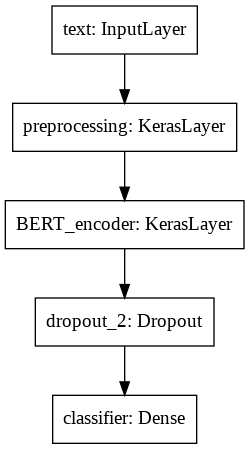

In [17]:
tf.keras.utils.plot_model(classifier_model)

In [23]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

24


In [24]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/3
8/8 [==============================] - 15s 977ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.2445 - val_sparse_categorical_accuracy: 0.9500
Epoch 2/3
8/8 [==============================] - 7s 892ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.3039 - val_sparse_categorical_accuracy: 0.9167
Epoch 3/3
8/8 [==============================] - 7s 891ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.2644 - val_sparse_categorical_accuracy: 0.9500


In [35]:
import numpy as np

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : class: {class_names[np.argmax(results[i])] }'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = ['德国米技（MIJI）蒸汽喷淋式煮茶壶 全自动保温泡茶壶HK-K018',
            '公牛插座收纳盒装办公接线板家用创意电源',
            '生活元素烧水壶办公室家用多功能小型烧水壶保温一体煮茶器煮茶壶',
            '信安智囊老人防摔防跌倒术后保护重复使用智能气囊马甲服神器送礼',
            '七度空间卫生巾优雅系列日夜超值组合',
            ' 【贝拉家】贝拉爸爸自己家工厂生产的科技布狗窝']
example_result = classifier_model(tf.constant(examples))

print_my_examples(examples,example_result)
#print(example_result)
#print(np.argmax(example_result.numpy()))
#print(class_names[np.argmax(example_result.numpy())])

input: 德国米技（MIJI）蒸汽喷淋式煮茶壶 全自动保温泡茶壶HK-K018 : class: CYJ
input: 公牛插座收纳盒装办公接线板家用创意电源            : class: SNQJ
input: 生活元素烧水壶办公室家用多功能小型烧水壶保温一体煮茶器煮茶壶 : class: CFPR
input: 信安智囊老人防摔防跌倒术后保护重复使用智能气囊马甲服神器送礼 : class: JJLP
input: 七度空间卫生巾优雅系列日夜超值组合              : class: ZPQJ
input:  【贝拉家】贝拉爸爸自己家工厂生产的科技布狗窝        : class: CWYP



In [1]:
import zipfile
from pathlib import Path
zFile = zipfile.ZipFile("/content/家居宠物.zip","r")
for fileM in zFile.namelist(): 
        zFile.extract(fileM, "/content/家居宠物")
zFile.close();

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '家居宠物/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
print(class_names)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '家居宠物/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 300 files belonging to 6 classes.
Using 240 files for training.
['CFPR', 'CWYP', 'CYJ', 'JJLP', 'SNQJ', 'ZPQJ']
Found 300 files belonging to 6 classes.
Using 60 files for validation.


In [10]:
for text_batch, label_batch in train_ds.take(1):
  print(text_batch)
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

tf.Tensor(
[b'\xe7\xb2\x98\xe6\xaf\x9b\xe5\x99\xa8\xe7\xbb\x84\xe5\x90\x88\xe3\x80\x902\xe4\xb8\xaa\xe6\x8a\x8a\xe6\x89\x8b+5\xe4\xb8\xaa\xe7\xb2\x98\xe6\xaf\x9b\xe5\x8d\xb7\xe3\x80\x91'
 b'\xe3\x80\x90\xe6\xad\xa3\xe5\xae\x97\xe7\xba\xa2\xe9\x93\x81\xe6\x9c\xa8\xe3\x80\x9128\xc3\x974cm-\xe6\x8e\xa8\xe8\x8d\x90\xe9\xbb\x84\xe9\x87\x91\xe5\x8d\x95\xe8\xba\xab\xe5\xae\xb6\xe5\xba\xad\xe4\xbd\xbf\xe7\x94\xa8'
 b'Q\xe8\xa2\x8b\xe8\x8c\xb6\xe5\x8f\xb6\xe7\xbd\x90'
 b'\xe9\xbd\x90\xe5\xa6\x99\xe4\xb8\xbb\xe5\xa6\x87 \xe5\xae\xb6\xe7\x94\xa8\xe6\xb3\x95\xe6\x96\x87\xe7\xa2\x97'
 b'\xe7\xb4\xa2\xe5\xac\x89\xe7\xbb\xb5\xe6\x9f\x94\xe6\xb4\x81\xe9\x9d\xa2\xe5\xb7\xbe'
 b'\xe7\x88\xb1\xe4\xb8\xbd\xe6\x80\x9d\xe5\xae\xa0\xe7\x89\xa9\xe7\x8b\x97\xe7\xb2\xae\xe8\x87\xaa\xe5\x8a\xa8\xe5\x96\x82\xe9\xa3\x9f\xe5\x99\xa8\xe7\xbb\x99\xe9\xa3\x9f\xe5\x99\xa8\xe5\x96\x82\xe6\xb0\xb4\xe5\x99\xa8\xe7\x88\xb1\xe4\xb8\xbd\xe4\xb8\x9d\xe7\x8b\x97\xe7\x8b\x97\xe7\x8c\xab\xe5\x92\xaa\xe6\x8a\x95\xe9\xa3\x9f\xe9\x